In [1]:
import numpy as np
from numpy import linalg as lin
import random as rn
from pyvis.network import Network
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import triad_utils as tu

In [3]:
# UNIX
! rm net_names.txt
#v1) ! ls database >> net_names.txt
! ls matrices >> net_names.txt

In [4]:
# NOTES
# The input file 'Fanconi anemia and checkpoint recovery.txt'
# was fixed manually, because the node 'DSB' is not formatted in a uniform way.

In [5]:
file = open('net_names.txt')
net_names = [name.rstrip() for name in file]

In [6]:
len(net_names)

71

In [7]:
census = []
for net_num in range(len(net_names)):
    matrix = np.loadtxt('matrices/'+net_names[net_num], dtype=int)
    n = len(matrix)
    for i in range(n):
        matrix[i,i] = 0 # removal of self-loops
    t = tu.triad_census(matrix)
    census.append(list(t))
    
df1 = pd.DataFrame(census)
df1.columns = ['t'+str(i) for i in range(1,14)]
df1.to_csv('triads_count.csv')

In [8]:
df1.head()

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13
0,33,31,87,10,18,0,8,1,0,1,2,0,1
1,47,34,53,18,20,3,51,4,1,6,12,5,0
2,123,85,180,22,26,2,38,3,3,0,7,0,0
3,9,12,25,13,6,2,1,0,2,2,1,3,1
4,36,44,68,12,8,0,2,1,0,0,0,0,0


In [9]:
norm_df1 = df1.div(df1.sum(axis=1), axis=0) 

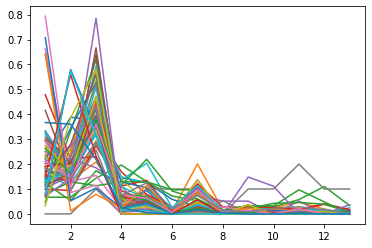

In [11]:
for i in range(len(norm_df1)):
    pr = norm_df1.loc[i]
    t = np.arange(1,14)
    plt.plot(t,pr)

In [12]:
data = [ list(norm_df1['t'+str(i+1)]) for i in range(13) ]

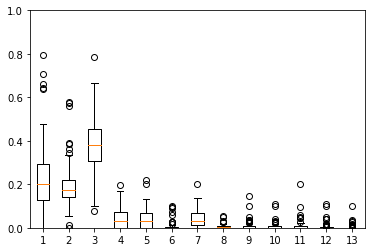

In [13]:
plt.boxplot(data,notch=False)
plt.ylim(0,1);

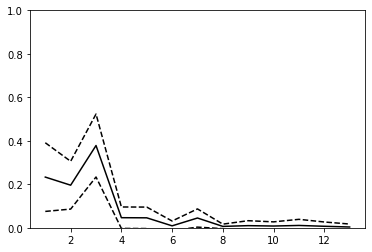

In [14]:
m = norm_df1.mean()
s = norm_df1.std()

plt.plot(t,m,'k')
plt.plot(t,m+s,'k--')
plt.plot(t,m-s,'k--')
plt.ylim(0,1);

In [15]:
df1.mean(axis=1,numeric_only=True)

0     14.769231
1     19.538462
2     37.615385
3      5.923077
4     13.153846
        ...    
66    10.923077
67    74.538462
68     2.384615
69     5.615385
70    34.384615
Length: 71, dtype: float64

# Random

In [16]:
tu.functions()

triad_census(matrix)
random_adj_matrix(N,p)
edge_list(adjacency_matrix)
adjacency_matrix(edge_list,size)
swap_edges(edge_list)
randomize(matrix,iterations)
triad_significance_profile(matrix, ensemble_size, edge_randomizations):
functions()



In [17]:
ensemble_size = 10

significance = []

for net_num in range(len(net_names)):
    matrix = np.loadtxt('matrices/'+net_names[net_num], dtype=int)
    n = len(matrix)
    n_edges = len(tu.edge_list(matrix))
    
    for i in range(n):
        matrix[i,i] = 0 # removal of self-loops
    t = tu.triad_significance_profile(matrix, ensemble_size, 100*n_edges)
    significance.append(list(t))
    
    print(net_num)
    
df2 = pd.DataFrame(significance)
df2.columns = ['t'+str(i) for i in range(1,14)]
df2.to_csv('significance_profiles.csv')

/Users/Enrico/Desktop/Triads-main/triad_utils.py:155: RuntimeWarning: divide by zero encountered in true_divide
  return (p-m)/s
/Users/Enrico/Desktop/Triads-main/triad_utils.py:155: RuntimeWarning: invalid value encountered in true_divide
  return (p-m)/s


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


In [19]:
#df_result = pd.DataFrame(result)
df2

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13
0,-4.310416,-3.850268,-3.300092,1.072490,2.502424,NaN,2.194680,-1.154701,NaN,inf,2.857738,NaN,inf
1,1.322901,-0.095238,0.729315,0.537086,-0.776282,-0.378811,1.084039,-0.101073,-1.698398,-1.848947,1.240128,-0.258738,-0.654654
2,-5.810196,-7.667346,-4.470312,1.431356,1.431276,4.500000,7.511799,-1.345955,5.307228,-0.745356,11.333333,NaN,NaN
3,-1.890103,-4.183811,-2.298117,0.915929,-1.583333,0.589506,-1.816217,-1.664479,2.412091,2.030259,-1.000000,9.666667,inf
4,1.886045,0.931614,0.170114,1.472971,1.337929,-0.333333,-2.797366,-0.726900,-0.333333,-0.333333,-1.224745,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,-5.204189,-6.030227,-3.380676,1.833157,1.750315,inf,2.716099,-0.845154,6.333333,-0.333333,3.000000,NaN,NaN
67,-0.528548,0.027880,-0.114456,-0.312992,0.199277,0.049207,-0.389974,-0.966961,-0.995863,0.230259,0.323531,0.827188,0.888523
68,0.654654,0.570352,0.812665,-0.500000,-0.500000,NaN,-0.333333,-0.500000,NaN,NaN,NaN,NaN,NaN
69,0.792406,0.845771,0.327761,-0.443079,0.272727,-0.333333,-1.165998,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#OLD - DON'T RUN - DON'T CONVERT
df_result

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-3.399446,-2.704910,-2.609261,0.974150,1.927938,-0.415873,1.718917,-0.939493,-0.378030,2.013752,2.293413,-0.187908,31.606961
1,1.407582,0.279306,1.183769,0.319794,-0.778199,-0.203238,0.870920,-0.324433,-1.842739,-1.528716,0.957386,0.342143,-0.516259
2,-4.561534,-4.753500,-3.717803,0.923856,1.309640,2.365893,5.342871,-0.528794,3.112899,-0.625161,6.437806,-0.223585,-0.031639
3,-1.394194,-2.705850,-1.656846,0.604469,-0.993703,0.338188,-1.187331,-1.240699,2.458604,1.514773,-0.388776,3.732432,6.377042
4,1.301886,0.725076,0.409195,0.822258,0.814937,-0.452827,-1.981764,-0.675261,-0.703073,-0.522900,-0.805018,-0.268952,-0.031639
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,-3.370922,-4.012273,-2.752240,1.114024,0.779894,1.676100,2.785289,-0.816499,3.322625,-0.428679,3.380630,-0.146460,1.000000
67,-1.029456,-0.256551,-0.581163,-0.152893,0.497189,0.662272,-0.790404,-1.235055,-1.046828,0.550649,0.429561,1.030043,2.005251
68,0.772945,0.855883,1.195815,-0.765660,-0.520238,-0.054855,-0.384845,-0.602012,-0.063372,1.000000,-0.160128,1.000000,1.000000
69,0.711356,0.777923,0.287814,-0.318398,0.483145,-0.119159,-1.149773,-0.425169,-0.153432,-0.119159,-0.201701,-0.044766,1.000000


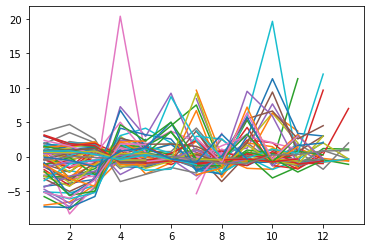

In [20]:
for i in range(len(df2)):
    pr = np.array(df2.loc[i])[:13]
    t = np.arange(1,14)
    plt.plot(t,pr)

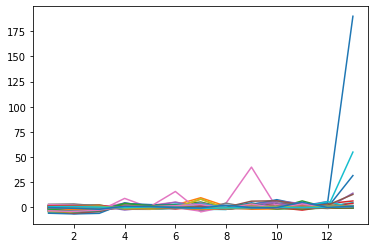

In [21]:
#OLD - DON'T RUN - DON'T CONVERT

for i in range(len(df_result)):
    pr = np.array(df_result.loc[i])[:13]
    t = np.arange(1,14)
    plt.plot(t,pr)

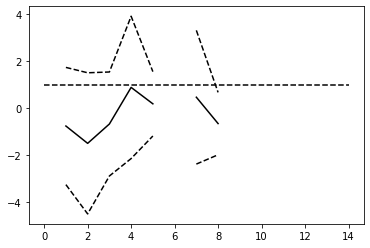

In [21]:
m = df2.mean()
s = df2.std()

plt.plot(t,m,'k')
plt.plot(t,m+s,'k--')
plt.plot(t,m-s,'k--')

plt.plot([0,14],[1,1],'--k')

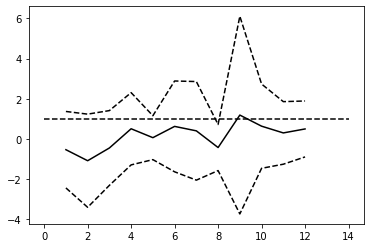

In [22]:
#OLD - DON'T RUN - DON'T CONVERT

m = df_result.mean()
s = df_result.std()

plt.plot(t,m,'k')
plt.plot(t,m+s,'k--')
plt.plot(t,m-s,'k--')

plt.plot([0,14],[1,1],'--k')